# Практика №3

Теперь в качестве акустической модели мы будем использовать простой DNN классификатор. На каждом кадре записи мы будем подавать его вектор признаков на DNN, которая будет выдавать "распределение вероятностей" по фонемам. Далее это распределение мы будем использовать в нашем алгоритме распознавания по словарю. Схема работы такого классификатора представлена ниже: 

![](https://drive.google.com/uc?export=view&id=1dv0VuE8DIoKXETbvnZq2PMixkWMCJOxr)

### Bootstrap

In [3]:
!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv lab2 lab3
!mv train_librispeech_10h lab3/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab3

Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 26.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
679MB [00:04, 161MB/s]
mv: cannot move 'train_librispeech_10h' to 'lab3/data/train_librispeech_10h': Directory not empty
/content/lab3


In [1]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import torch
import torch.nn as nn
import torch.functional as F


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
# загрузка списка допустимых фонем:
def load_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for index, line in enumerate(fn):
            phones_dict[line.strip()] = index
    return phones_dict

# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    step = 0
    for wav_name in tqdm(os.listdir(dir_path)):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        step += 1
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict


phones_file = 'data/train_librispeech_10h/phones'
phones_dict = load_phones_dict(phones_file)

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

train_records_dir = 'data/train_librispeech_10h/wav_dir'
feats_dict = load_data_dict(train_records_dir, count=3000)

Early stop at 3000th file..


### Априорная вероятность:

![](https://drive.google.com/uc?export=view&id=1WhjclhXm2POYsCgvxp3iAIOvT9F_k8If)

In [5]:
# объединение кадров признаков с соответствующими им фонемам:
def combain_data(ali_dict, feats_dict, phones_dict, side_context=None):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        file_ali = ali_dict[file_name]
        n_dim = min(len(file_feats), len(file_ali))
        for frame in range(n_dim):

            data = []

            #left
            for side_left in range(frame - side_context, frame):
                if side_left < 0:
                    data.append(
                        np.zeros(
                          shape=(13,),
                          dtype=np.float64,
                        )
                    )
                else:
                    data.append(file_feats[side_left])

            #center
            data.append(file_feats[frame])

            #right
            for side_right in range(frame + 1, frame + side_context + 1):
                if side_right < n_dim:
                    data.append(file_feats[side_right])
                else:
                    data.append(
                        np.zeros(
                          shape=(13,),
                          dtype=np.float64,
                        )
                    )

            data = np.concatenate(data)

            data_list.append(np.append(data, phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1
    return data_list, np.array(priors_list)/sum(priors_list)

side_context = 3
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [6]:
class CommonDataSet():

    def __init__(self, data_list, device, valid_proportion=0.1):
        self.train = data_list[:int((1-valid_proportion)*len(data_list))]
        self.valid = data_list[int((1-valid_proportion)*len(data_list)):]
        self.device = device
        
    def num_batches(self, batch_size):
        return len(self.train)//batch_size        
        
    def next_batch(self, batch_size):
        for i in range(self.num_batches(batch_size)):
            batch_xs = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size, :-1], dtype=torch.float32)
            batch_ys = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size,-1].ravel(), dtype=torch.int64)

            yield batch_xs.to(device), batch_ys.to(device)

In [7]:
class MyNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNet, self).__init__()
        # params:
        input_dim = input_dim       # размерность входных признаков
        n_nodes_hl1 = 256
        n_nodes_hl2 = 256
        n_nodes_hl3 = 256
        n_nodes_hl4 = 256
        output_dim = output_dim     # количество выходных классов (фонем)
        # FC layers:
        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
        self.fc5 = nn.Linear(n_nodes_hl4, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return (x)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
net = MyNet(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.9)

loss_list = []

print('TRAINIG IS STARTED...')
for epoch in range(120):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = net(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)

    lr_scheduler.step()
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG IS STARTED...



loss is: 1.6095



loss is: 1.4984



loss is: 1.4723



loss is: 1.4584



loss is: 1.4331



loss is: 1.4241



loss is: 1.4195



loss is: 1.4145



loss is: 1.3972



loss is: 1.3929



loss is: 1.3893



loss is: 1.3863



loss is: 1.3719



loss is: 1.3678



loss is: 1.3665



loss is: 1.3641



loss is: 1.3523



loss is: 1.3490



loss is: 1.3478



loss is: 1.3459



loss is: 1.3368



loss is: 1.3326



loss is: 1.3314



loss is: 1.3309



loss is: 1.3204



loss is: 1.3186



loss is: 1.3173



loss is: 1.3175



loss is: 1.3073



loss is: 1.3063



loss is: 1.3052



loss is: 1.3040



loss is: 1.2968



loss is: 1.2947



loss is: 1.2944



loss is: 1.2947



loss is: 1.2866



loss is: 1.2879



loss is: 1.2839



loss is: 1.2859



loss is: 1.2775



loss is: 1.2764



loss is: 1.2761



loss is: 1.2742



loss is: 1.2698



loss is: 1.2681



loss is: 1.2683



loss is: 1.2672



loss is: 1.2614



loss is: 1.2606



loss is: 1.2601



loss is: 1.2600



loss is: 1.2552



loss is: 1.2542



loss is: 1.2540



loss is: 1.2531



loss is: 1.2492



loss is: 1.2480



loss is: 1.2494



loss is: 1.2475



loss is: 1.2434



loss is: 1.2427



loss is: 1.2438



loss is: 1.2414



loss is: 1.2377



loss is: 1.2382



loss is: 1.2373



loss is: 1.2371



loss is: 1.2334



loss is: 1.2336



loss is: 1.2338



loss is: 1.2332



loss is: 1.2298



loss is: 1.2291



loss is: 1.2284



loss is: 1.2287



loss is: 1.2255



loss is: 1.2255



loss is: 1.2253



loss is: 1.2255



loss is: 1.2221



loss is: 1.2219



loss is: 1.2217



loss is: 1.2213



loss is: 1.2189



loss is: 1.2181



loss is: 1.2185



loss is: 1.2179



loss is: 1.2158



loss is: 1.2154



loss is: 1.2151



loss is: 1.2155



loss is: 1.2129



loss is: 1.2129



loss is: 1.2129



loss is: 1.2126



loss is: 1.2110



loss is: 1.2105



loss is: 1.2105



loss is: 1.2102



loss is: 1.2089



loss is: 1.2084



loss is: 1.2083



loss is: 1.2081



loss is: 1.2068



loss is: 1.2065



loss is: 1.2064



loss is: 1.2062



loss is: 1.2049



loss is: 1.2047



loss is: 1.2046



loss is: 1.2046



loss is: 1.2034



loss is: 1.2031



loss is: 1.2030



loss is: 1.2030



loss is: 1.2017



loss is: 1.2016



loss is: 1.2015



loss is: 1.2013
Time is: 60 min 6 sec


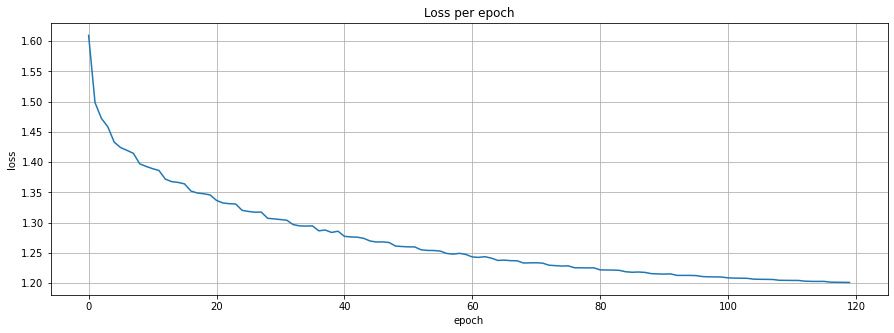

In [9]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [10]:
net
with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float().cuda()
        output = net(ftr)
        correct_cnt += (output.argmax().item() == true_label)
        
    print("Total frame accuracy is {:.3f}".format(correct_cnt / data_set.valid.shape[0]))


Total frame accuracy is 0.615


In [11]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]
net.cpu()
with torch.no_grad():
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = net.forward(ftr)
        predict_label = output.argmax().item()
        
        class_correct[predict_label] += (predict_label == int(true_label))
        class_total[int(true_label)] += 1

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))


SIL: 0.97 : 65738/68064
SPN: 0.00 : 3/1761
AA0: 0.00 : 0/113
AA1: 0.48 : 2655/5475
AA2: 0.00 : 0/278
AE0: 0.00 : 0/141
AE1: 0.57 : 6060/10574
AE2: 0.00 : 0/304
AH0: 0.50 : 8310/16714
AH1: 0.34 : 1970/5748
AH2: 0.00 : 0/114
AO0: 0.00 : 0/74
AO1: 0.53 : 2991/5660
AO2: 0.00 : 0/165
AW0: 0.00 : 0/23
AW1: 0.39 : 1250/3232
AW2: 0.01 : 1/108
AY0: 0.00 : 0/136
AY1: 0.67 : 5848/8752
AY2: 0.00 : 2/587
B  : 0.48 : 2214/4627
CH : 0.43 : 1112/2589
D  : 0.40 : 4725/11877
DH : 0.51 : 3051/5949
EH0: 0.02 : 3/183
EH1: 0.39 : 3288/8490
EH2: 0.00 : 0/299
ER0: 0.48 : 3779/7817
ER1: 0.32 : 882/2726
ER2: 0.00 : 0/33
EY0: 0.00 : 0/86
EY1: 0.62 : 4468/7157
EY2: 0.00 : 0/398
F  : 0.70 : 4956/7128
G  : 0.34 : 851/2525
HH : 0.51 : 3372/6661
IH0: 0.25 : 1968/8016
IH1: 0.34 : 2381/7054
IH2: 0.00 : 0/295
IY0: 0.49 : 3344/6798
IY1: 0.56 : 4021/7136
IY2: 0.00 : 0/167
JH : 0.34 : 696/2028
K  : 0.64 : 5809/9144
L  : 0.69 : 8826/12724
M  : 0.57 : 5394/9399
N  : 0.69 : 12402/17918
NG : 0.48 : 1921/3974
OW0: 0.00 : 0/582

### Распознавание по словарю с помощью нейронки

In [12]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

In [13]:
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet):
        with torch.no_grad():
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))
            softmax = torch.nn.functional.softmax(predicts, dim=0)
        return -np.log(softmax[self.phone_index].item() / self.phone_prior)

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [14]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    alive_tokens = [token for token in next_tokens if token.alive]
    best_token = alive_tokens[np.argmin([token.dist for token in alive_tokens if token.alive])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for i in range(len(next_tokens)): 
        state_index = next_tokens[i].state.index
        if not graph[state_index].best_token:
            graph[state_index].best_token = next_tokens[i]
        else:
            if next_tokens[i].dist <= graph[state_index].best_token.dist:
                graph[state_index].best_token.alive = False
                graph[state_index].best_token = next_tokens[i]
            else:
                next_tokens[i].alive = False
    for token in next_tokens:                           
        index = token.state.index                        
        if graph[index].best_token:                     
            graph[index].best_token = None              
    return next_tokens


def recognize(filename, features, graph, nnet, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    
    n_dim = len(features)
    for frame in range(n_dim):

        data = []

        #left
        for side_left in range(frame - side_context, frame):
            if side_left < 0:
                data.append(
                    np.zeros(
                      shape=(13,),
                      dtype=np.float64,
                    )
                )
            else:
                data.append(features[side_left])

        #center
        data.append(features[frame])

        #right
        for side_right in range(frame + 1, frame + side_context + 1):
            if side_right < n_dim:
                data.append(features[side_right])
            else:
                data.append(
                    np.zeros(
                      shape=(13,),
                      dtype=np.float64,
                    )
                )

        ftr_frame = np.concatenate(data)

        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [15]:
def run_recognizer(records_data_dict, graph, nnet, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename,
                                        records_data_dict[filename],
                                        graph, nnet,
                                        recognition_results, beam_threshold)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

### Запустим распознавание на базе YES_NO

In [16]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=100)


result: yes_39a12648_nohash_0       ==> YES


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


result: no_49af4432_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> NO
result: no_4394fc7c_nohash_0        ==> NO
result: no_41474817_nohash_0        ==> NO
------------------------------------------------------------
WER is: 0.00%
Total time is: 1.47 sec
------------------------------------------------------------


### Запустим распознавание на базе Digits

In [17]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


result: one_fc2411fe_nohash_0       ==> ONE
result: five_f852895b_nohash_0      ==> FIVE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: nine_fbe51750_nohash_0      ==> NINE
result: seven_fd32732a_nohash_0     ==> SEVEN
result: one_ffa76c4a_nohash_0       ==> ONE
result: four_fce65496_nohash_0      ==> FOUR
result: nine_ccea893d_nohash_0      ==> NINE
result: three_feb1d305_nohash_0     ==> THREE
result: three_fce96bac_nohash_0     ==> THREE
result: six_ffbb695d_nohash_0       ==> SIX
result: eight_daf230ac_nohash_0     ==> EIGHT
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: eight_da584bc0_nohash_4     ==> EIGHT
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: four_ffbb695d_nohash_0      ==> FOUR
result: two_fce65496_nohash_0       ==> TWO
result: six_ffd2ba2f_nohash_0       ==> SIX
result: zero_f852895b_nohash_0      ==> ZERO
result: two_fb2f3242_nohash_0       ==> TWO
------------------------------------------------------------
WER is: 0.00%
Total time is: 10.57 sec


### <b>Задание №1</b> (5 баллов):
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего. Не забудьте поддержать это и в функции распознавания. Насколько улучшилось качество на дата сетах?

![](https://drive.google.com/uc?export=view&id=1ft0z6CPhX20cJnA373uLoYwHPEagaKyo)

### <b>Задание №2</b> (5 баллов):
Повысить качество классификации фонем за счет улучшения архитектуры нейронной сети, оптимизатора, других речевых признаков и т.п. Составить небольшой отчет на основе результатов перебора использованных способов. 

In [18]:
nets = ['MyNet', 'MyNet', 'MyNet', ]
side_context = [3, 3, 3, ]
min_loss = [1.07, 1.1810, 1.2013, ]
TFA = [0.594, 0.608, 0.615, ]
YN = [10, 0, 0, ]
Digits = [15, 5, 0, ]
n_data = [1000, 2000, 3000, ]

import pandas as pd
pd.DataFrame(
    {'side context': side_context,
     'min loss': min_loss,
     'Total frame accuracy': TFA,
     'YesNo WER': YN,
     'Digits WER': Digits,
     'N files': n_data,
     'Nets': nets,
     },
)

,side context,min loss,Total frame accuracy,YesNo WER,Digits WER,N files,Nets
0,3,1.0700,0.594,10,15,1000,MyNet
1,3,1.1810,0.608,0,5,2000,MyNet
2,3,1.2013,0.615,0,0,3000,MyNet


Прошлый отчет

In [19]:
nets = ['MyNet', 'MyNet', 'MyNet', 'MyNet', 'MyNet', 'MyNet2']
side_context = [0, 1, 2, 3, 3, 0]
min_loss = [2.1420, 2.0081, 1.9031, 1.8410, 1.9495, 2.1550,]
TFA = [0.407, 0.430, 0.449, 0.466, 0.444, 0.173,]
YN = [10, 0, 0, 0, 0, 50]
Digits = [25, 25, 10, 10, 25, 90, ]
n_data = [1000, 1000, 1000, 1000, 2000, 2000]

import pandas as pd
pd.DataFrame(
    {'side context': side_context,
     'min loss': min_loss,
     'Total frame accuracy': TFA,
     'YesNo WER': YN,
     'Digits WER': Digits,
     'N files': n_data,
     'Nets': nets,
     },
)

,side context,min loss,Total frame accuracy,YesNo WER,Digits WER,N files,Nets
0,0,2.1420,0.407,10,25,1000,MyNet
1,1,2.0081,0.430,0,25,1000,MyNet
2,2,1.9031,0.449,0,10,1000,MyNet
3,3,1.8410,0.466,0,10,1000,MyNet
4,3,1.9495,0.444,0,25,2000,MyNet
5,0,2.1550,0.173,50,90,2000,MyNet2


Использовалась стандартная сеть с разными side_context и N files на входе. Действительно получилось увеличить качество распознавания при увеличении окружения, но, что странно, увеличение выборки не дало прироста к качеству. Во всех экспериментах использовался optimizer = torch.optim.Adam(net.parameters(), lr=0.01) и  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.5). Обучалось 30 эпох с батчом 256.
Побоялся проводить больше экспериметов с N files, поскольку на первом эксперименте дало ухудшение.
Как показывает практика, сверточные нейросети быстрее переобучаются под один класс, который чаще встречается, поэтому скорее всего необходимо использовать другой Loss (например, Weighted CELoss, FocalLoss)

Видно, что измененная архитектура сбора данных (паддинг и тд.) + более точная настройка ленинг рейта помогла добиться WER 0%.

Сейчас модель обучалась 120 эпох с 

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.9)